# Predicting Marginal Generating Units in ERCOT

## Project Goals and Model Choices
The primary goal of this project is to build a model that can predict the type of fossil marginal generating units (MGU) that will provide electricity for any additional demand at a given time. This type of problem can be very difficult to solve, especially if the model is also trying to account for factors such as the current demand or the current generation of variable renewable power. We are simplifying the model by treating all inputs as exogenous - e.g., the time of day or day of the year doesn't matter, because we are specifying the current demand and current variable renewable power production.

Trying to predict which individual power plant will provide marginal generation under a given set of grid conditions is difficult and prone to overfitting. Instead, we will combine individual fossil power plants into groups based on their fuel type, heat rate, and historical operating behavior using k-means clustering.

We are using 9 years (2007-2015) of hourly generation and load data for the ERCOT power grid. Using ERCOT also helps to simplify the model, because it does not trade electricity with either the Eastern or Western Interconnections. Over the 9 years of data we see a large increase in the amount of wind generation in ERCOT, and increased generation from natural gas power plants.

## Model Inputs
As currently planned, the model will have the following inputs:
- Current installed capacity for wind and each fossil group
- Current free capacity of each fossil group
    - This serves to normalize inputs; available capacity for additional generation
- Current wind generation
    - We only have hourly wind generation, but effects of intra-hour variability on the system should increase when wind generation is high
- Wind generation in recent past (past 1, 2, ..., n hours - maybe up to n=5?)
    - Combined with change in demand to create a change in "net load" to account for ramp rate constraints
- Fuel price for electric customers in TX from EIA

## Data Sources
We are using data from ERCOT, EIA, and EPA as described below.
- ERCOT
    - Hourly wind generation
    - Total hourly demand
- EIA
    - Average heat rate and primary fuel source for each power plant (Form 923)
    - Maximum generating capacity of each power plant (Form 860)
    - Historical annual and monthly capacity factors for each power plant (923 and 860)
    - Historical natural gas prices for electric customers (monthly)
- EPA
    - Hourly gross load (MW) for every fossil power plant in ERCOT

## Initial Data Exploration
Our work so far has primarily consisted of model design and data collection. We have collected all of the data described above, and started importing/cleaning/merging data. 

### Fossil Power Plants (EIA data)
The figure below shows all ERCOT fossil power plants active in 2007. Non-fossil power plants have already been removed from the dataset. Unsurprisingly, the coal power plants were running at high capacity factors. Natural gas power plants covered a wide range of sizes from a few dozen MW to over 2 GW. The larger plants also tended to be used far less than either smaller gas plants or coal plants. There are a couple diesel (DFO) and petroleum coke (PC) power plants that show up, but they are usually small. We might check the one larger PC facility to make sure there hasn't been an error with the data processing.

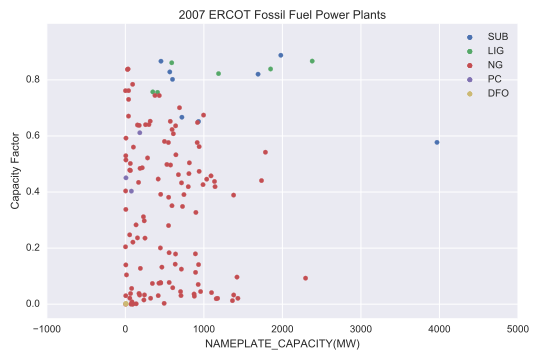

In [6]:
from IPython.display import SVG
SVG('https://www.dropbox.com/s/k8ac0la03hkjo5f/ERCOT%20power%20plants%202007.svg?raw=1')

### Hourly Fossil Power Plant Generation (EPA data)
This figure shows the hourly gross load from three sample plants over the last 6 months of 2015. The primary goal here is to ensure that the data import, conversion, and `datetime` object creation was all done correctly. These three sample plants do happen to show a range of different sizes and behaviors. 

The left and middle plants have minimum operating loads, below which they do not generate. This is one difficulty that we are trying to get around with treating groups of facilities as large power plants - we care about the group behavior rather than if an individual power plant goes from off to on or just produces a little more power.

The plant on the right consists of two natural gas combustion turbines, which can quickly turn on and ramp up. It never appears to hit its maximum of ~250MW.

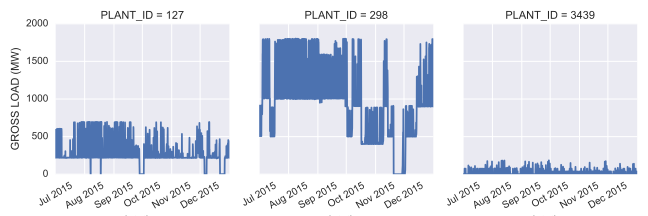

In [7]:
SVG('https://www.dropbox.com/s/k79xmwfbu4dt16h/Sample%20hourly%20load.svg?raw=1')

### Distribution of Wind Power Over Time (ERCOT data)
ERCOT provides hourly data of load, wind generation, and the percent of load that is served by wind generation. This figure shows the distribution of that last set of data by year from 2007-2015. Its obvious that more and more of the load is served by wind each year. The distribution also flattens out - fewer hours see a very small amount of the load covered by wind. 

Each violin has a small boxplot in the middle of it. The white circle at the center shows the median value for that year. Notice that the amount of load covered by wind in the median hour keeps going up, and was over 10% in 2015.

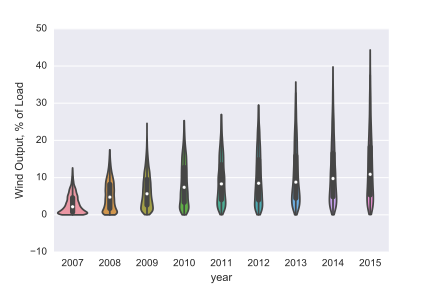

In [8]:
SVG('https://www.dropbox.com/s/wjpa9sbj3sklpfc/Wind%20violin%20plot.svg?raw=1')

### ERCOT Load and Wind Generation Over Time
The figures below show average hourly load and wind generation by month over the years 2007-2015. Load (on the left) follows a predictable pattern with peak demand in the summer months. Wind generation (on the right) is a little messier. Over most of the years there is a dip in production during summer months, but we don't see the same dip in 2015.

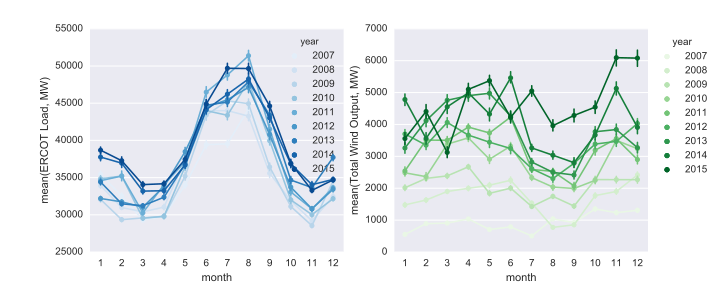

In [9]:
SVG('https://www.dropbox.com/s/onet87a33pjvhym/Monthly%20ERCOT%20load%20and%20wind2.svg?raw=1')

### ERCOT Installed Wind Capacity
This may solve some of the mystery from the figure above. It looks like there was lots of wind installed over the course of 2015, which could have helped bump up the output.

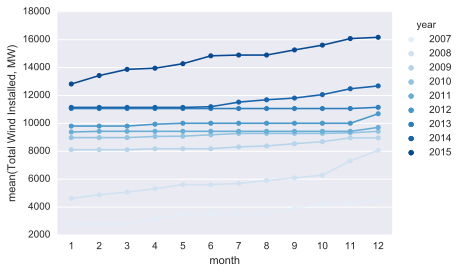

In [10]:
SVG('https://www.dropbox.com/s/9k7nyhjt78k1quy/Monthly%20ERCOT%20wind%20capacity.svg?raw=1')

## Next Steps
Now that we have the required data, we still need to:
- Calculate historical ramp rates from the EPA hourly gross generation data
- Cluster power plants using k-means
    - If the unsupervised clustering doesn't give reasonable results, we will use expert judgment to group the facilities
- Split the 9 years of hourly data into training and testing sets
- Design and train a model